# Set up

In [2]:
import os
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import cv2
import urllib.request
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython.display import display
import ipytest
ipytest.autoconfig()
import pytest
import numpy.testing as npt

# Getting some unknown linter errors, disable everything to get this to production asap
# pylint: disable-all

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable Tensorflow logging

model_url = 'https://tfhub.dev/google/aiy/vision/classifier/birds_V1/1'
labels_url = 'https://www.gstatic.com/aihub/tfhub/labelmaps/aiy_birds_V1_labelmap.csv'

image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/c/c8/Phalacrocorax_varius_-Waikawa%2C_Marlborough%2C_New_Zealand-8.jpg',
    'https://quiz.natureid.no/bird/db_media/eBook/679edc606d9a363f775dabf0497d31de8c3d7060.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/8/81/Eumomota_superciliosa.jpg',
    'https://i.pinimg.com/originals/f3/fb/92/f3fb92afce5ddff09a7370d90d021225.jpg',
    'https://cdn.britannica.com/77/189277-004-0A3BC3D4.jpg'
]

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Data

Names of recognizable birds.

In [3]:
data_label = pd.read_csv(labels_url)
data_label

,id,name
0,964,background
1,0,Haemorhous cassinii
2,1,Aramus guarauna
3,2,Rupornis magnirostris
4,3,Cyanocitta cristata
...,...,...
960,959,Garrulus glandarius
961,960,Anser anser domesticus
962,961,Mitrephanes phaeocercus
963,962,Ardenna creatopus


In [4]:
labels = dict(data_label.values)
labels[0]

'Haemorhous cassinii'

Image data

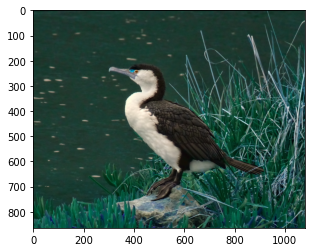

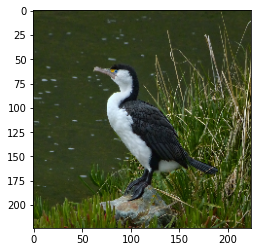

In [5]:
# Loading images
image_get_response = urllib.request.urlopen(image_urls[0])
image_array = np.asarray(bytearray(image_get_response.read()), dtype=np.uint8)

# Changing images
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.imshow(image)
plt.show()
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255
plt.imshow(image)

# Model

In [6]:
# Generate tensor
image_tensor = tf.convert_to_tensor([image], dtype=tf.float32)

# predict bird name
model = hub.KerasLayer(model_url)
prob = model.call(image_tensor).numpy()[0]  # probability for each bird
print(prob.shape)
top_indices = prob.argsort()[-1:-11:-1]  # indices of top 10 predictions
top_names = list(map(labels.get, top_indices))  # top 10 birds
top_scores = prob[top_indices]  # top 10 scores
print(top_names)
print(top_scores)
sum(top_scores)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(965,)
['Phalacrocorax varius varius', 'Phalacrocorax varius', 'Microcarbo melanoleucos', 'Microcarbo melanoleucos brevirostris', 'Phalacrocorax carbo', 'Branta leucopsis', 'Prosthemadera novaeseelandiae novaeseelandiae', 'Hemiphaga novaeseelandiae', 'Gymnorhina tibicen', 'Cinclus cinclus']
[8.5133559e-01 1.0837461e-01 2.4569901e-02 5.5703055e-03 7.7003933e-04
 3.1091165e-04 2.4278162e-04 1.4803851e-04 1.3632252e-04 1.3632252e-04]


0.9915948180278065

# Program

In [7]:
class BirdClassifier2:
    def __init__(self, online=True):
        """
        Identify name of bird based on image
        online: load classification model and label data online, otherwise from local machine
        """
        
        # classification model
        model_url = ("https://tfhub.dev/google/aiy/vision/classifier/birds_V1/1" if online
                     else "classifier")
        self.model = hub.KerasLayer(model_url)

        # recognizable bird names
        label_url = ("https://www.gstatic.com/aihub/tfhub/labelmaps/aiy_birds_V1_labelmap.csv" if online
                     else "classifier/labels.csv")
        data_label = pd.read_csv(label_url)
        self.labels = dict(data_label.values)
                
    @staticmethod
    def load_image(url):
        """
        Read image url into array (224, 224)
        """
        
        # Loading images
        image_get_response = urllib.request.urlopen(url)
        image_array = np.asarray(bytearray(image_get_response.read()), dtype=np.uint8)

        # Changing images
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255
        
        return image
    
    def identify(self, image_url):
        """
        Identify name of bird based on image url
        """
        
        # Generate tensor
        image = self.load_image(image_url)
        image_tensor = tf.convert_to_tensor([image], dtype=tf.float32)

        # predict bird name
        prob = self.model.call(image_tensor).numpy()[0]  # probability for each bird
        top_indices = prob.argsort()[::-1]  # indices of predictions from most to least
        top_names = list(map(self.labels.get, top_indices))  # bird names from most to least
        top_scores = prob[top_indices]  # scores from most to least
        
        return top_names, top_scores
    
start_time = time.time()
clf = BirdClassifier2()
for i, url in enumerate(image_urls):
    top_names, top_scores = clf.identify(url)
    # Print results to kubernetes log
    print(f'Run: {i + 1}')
    print(f'Top match: {top_names[0]} with score: {top_scores[0]}')
    print(f'Second match: {top_names[1]} with score: {top_scores[1]}')
    print(f'Third match: {top_names[2]} with score: {top_scores[2]}\n')
print(f'Time spent: {time.time() - start_time}')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Run: 1
Top match: Phalacrocorax varius varius with score: 0.8513355851173401
Second match: Phalacrocorax varius with score: 0.10837461054325104
Third match: Microcarbo melanoleucos with score: 0.024569900706410408

Run: 2
Top match: Galerida cristata with score: 0.828108012676239
Second match: Alauda arvensis with score: 0.08939234167337418
Third match: Eremophila alpestris with score: 0.022008126601576805

Run: 3
Top match: Eumomota superciliosa with score: 0.41272449493408203
Second match: Momotus coeruliceps with score: 0.052539676427841187
Third match: Momotus lessonii with score: 0.048381607979536057

Run: 4
Top match: Aulacorhynchus prasinus with score: 0.7977310419082642
Second match: Cyanocorax yncas with score: 0.1197560653090477
Third match: Chlorophanes spiza with score: 0.014038418419659138

Run: 5


# Test

In [8]:
%%ipytest

@pytest.fixture
def classifier():
    return BirdClassifier2()

@pytest.mark.parametrize('url', image_urls)
def test_load_image(classifier, url):
    image = classifier.load_image(url)
    assert image.shape == (224, 224, 3)
    assert np.all(image <= 1)  # normalized
    
@pytest.mark.parametrize('image_url,exp_top_3_names', [
    ('https://upload.wikimedia.org/wikipedia/commons/c/c8/Phalacrocorax_varius_-Waikawa%2C_Marlborough%2C_New_Zealand-8.jpg',
     ["Phalacrocorax varius varius", "Phalacrocorax varius", "Microcarbo melanoleucos"]),
    ('https://quiz.natureid.no/bird/db_media/eBook/679edc606d9a363f775dabf0497d31de8c3d7060.jpg',
     ["Galerida cristata", "Alauda arvensis", "Eremophila alpestris"]),
    ('https://upload.wikimedia.org/wikipedia/commons/8/81/Eumomota_superciliosa.jpg',
     ["Eumomota superciliosa", "Momotus coeruliceps", "Momotus lessonii"]),
    ('https://i.pinimg.com/originals/f3/fb/92/f3fb92afce5ddff09a7370d90d021225.jpg',
     ["Aulacorhynchus prasinus", "Cyanocorax yncas", "Chlorophanes spiza"]),
    ('https://cdn.britannica.com/77/189277-004-0A3BC3D4.jpg',
     ["Erithacus rubecula", "Ixoreus naevius", "Setophaga tigrina"])
])
def test_identify(classifier, image_url, exp_top_3_names):
    top_names, top_scores = classifier.identify(image_url)
    npt.assert_equal(top_names[:3], exp_top_3_names)
    npt.assert_array_less(top_scores[1:]/top_scores[0], 0.5)  # top probability more than twice others
    npt.assert_almost_equal(sum(top_scores), 1, decimal=5)  # total probability 1

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:

# Test offline

In [9]:
%%ipytest

@pytest.fixture
def classifier_offline():
    return BirdClassifier2(online=False)

local_dir = "file:///work/veriff-mobile-bird-classification"  # repository directory – change /kaggle/working to suit local file system
@pytest.mark.parametrize('url', [
    f"{local_dir}/images/Phalacrocorax varius varius.jpg",
    f"{local_dir}/images/Galerida cristata.jpg",
    f"{local_dir}/images/Eumomota superciliosa.jpg",
    f"{local_dir}/images/Aulacorhynchus prasinus.jpg",
    f"{local_dir}/images/Erithacus rubecula.jpg"
])
def test_load_image_offline(classifier_offline, url):
    """
    url: mocked by local file path
    """
    image = classifier_offline.load_image(url)
    assert image.shape == (224, 224, 3)
    assert np.all(image <= 1)  # normalized
    
@pytest.mark.parametrize('image_url,exp_top_3_names', [
    (f'{local_dir}/images/Phalacrocorax varius varius.jpg',
     ["Phalacrocorax varius varius", "Phalacrocorax varius", "Microcarbo melanoleucos"]),
    (f'{local_dir}/images/Galerida cristata.jpg',
     ["Galerida cristata", "Alauda arvensis", "Eremophila alpestris"]),
    (f'{local_dir}/images/Eumomota superciliosa.jpg',
     ["Eumomota superciliosa", "Momotus coeruliceps", "Momotus lessonii"]),
    (f'{local_dir}/images/Aulacorhynchus prasinus.jpg',
     ["Aulacorhynchus prasinus", "Cyanocorax yncas", "Chlorophanes spiza"]),
    (f'{local_dir}/images/Erithacus rubecula.jpg',
     ["Erithacus rubecula", "Ixoreus naevius", "Setophaga tigrina"])
])
def test_identify_offline(classifier_offline, image_url, exp_top_3_names):
    """
    image_url: mocked by local image file path
    """
    top_names, top_scores = classifier_offline.identify(image_url)
    npt.assert_equal(top_names[:3], exp_top_3_names)
    npt.assert_array_less(top_scores[1:]/top_scores[0], 0.5)  # top probability more than twice others
    npt.assert_almost_equal(sum(top_scores), 1, decimal=5)  # total probability 1

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
.INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:

# Original program

In [10]:
class BirdClassifier:
    @staticmethod
    def load_model():
        return hub.KerasLayer(model_url)

    def load_and_cleanup_labels(self):
        bird_labels_raw = urllib.request.urlopen(labels_url)
        bird_labels_lines = [line.decode('utf-8').replace('\n', '') for line in bird_labels_raw.readlines()]
        bird_labels_lines.pop(0)  # remove header (id, name)
        birds = {}
        for bird_line in bird_labels_lines:
            bird_id = int(bird_line.split(',')[0])
            bird_name = bird_line.split(',')[1]
            birds[bird_id] = {'name': bird_name}

        return birds

    def order_birds_by_result_score(self, model_raw_output, bird_labels):
        for index, value in np.ndenumerate(model_raw_output):
            bird_index = index[1]
            bird_labels[bird_index]['score'] = value

        return sorted(bird_labels.items(), key=lambda x: x[1]['score'])

    def get_top_n_result(self, top_index, birds_names_with_results_ordered):
        bird_name = birds_names_with_results_ordered[top_index*(-1)][1]['name']
        bird_score = birds_names_with_results_ordered[top_index*(-1)][1]['score']
        return bird_name, bird_score

    def main(self):
        for index, image_url in enumerate(image_urls):
            bird_model = self.load_model()
            bird_labels = self.load_and_cleanup_labels()
            # Loading images
            image_get_response = urllib.request.urlopen(image_url)
            image_array = np.asarray(bytearray(image_get_response.read()), dtype=np.uint8)
            # Changing images
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255
            # Generate tensor
            image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
            image_tensor = tf.expand_dims(image_tensor, 0)
            model_raw_output = bird_model.call(image_tensor).numpy()
            birds_names_with_results_ordered = self.order_birds_by_result_score(model_raw_output, bird_labels)
            # Print results to kubernetes log
            print('Run: %s' % int(index + 1))
            bird_name, bird_score = self.get_top_n_result(1, birds_names_with_results_ordered)
            print('Top match: "%s" with score: %s' % (bird_name, bird_score))
            bird_name, bird_score = self.get_top_n_result(2, birds_names_with_results_ordered)
            print('Second match: "%s" with score: %s' % (bird_name, bird_score))
            bird_name, bird_score = self.get_top_n_result(3, birds_names_with_results_ordered)
            print('Third match: "%s" with score: %s' % (bird_name, bird_score))
            print('\n')


if __name__ == "__main__":
    start_time = time.time()
    classifier = BirdClassifier()
    classifier.main()
    print('Time spent: %s' % (time.time() - start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Run: 1
Top match: "Phalacrocorax varius varius" with score: 0.8513356
Second match: "Phalacrocorax varius" with score: 0.10837461
Third match: "Microcarbo melanoleucos" with score: 0.0245699


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Run: 2
Top match: "Galerida cristata" with score: 0.828108
Second match: "Alauda arvensis" with score: 0.08939234
Third match: "Eremophila alpestris" with score: 0.022008127


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Run: 3
Top match: "Eumomota superciliosa" with score: 0.4127245
Second match: "Momotus coerulicep

# Performance analysis
**What have been done:**

* The class BirdClassifier was restructured to contain two methods—load_image and identify. These two methods reflect two main tasks of the classifier—acquiring image data and using image data to identify the kind of bird.

* Optimized reading labels (csv file) using pandas instead of parsing text, ordering predicted scores, storing predicted scores in array instead of nested dictionary.

* Focus classifier on single classification rather than multiple. Multiple classifications can be achieved by calling classifier multiple times.

**Performance**

New classifier takes ~7 seconds to run while the original takes ~15 seconds. Most runtime spent on classification task by classification model.

**Comments**

* Top predictions required are few, we may not need to sort all scores; rather we can use numpy argpartition when size of list grows large. May complicate code a bit.

* If Id in label data not important, we may use array instead of dictionary. Accessing array may be faster than dictionary due to dictionary calling hash function.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3ec90b06-16fb-4711-a41e-7ab7cebf27ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>